<a href="https://colab.research.google.com/github/amga-d/Indonesian-province-edu-poverty-analysis/blob/main/Analyze_literacy_and_Poverty_In__Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preprocessing


## 1.1 Process Poverty Data



In [ ]:
import numpy as np
import pandas as pd

def process_poverty_data(files):
    dfs = pd.DataFrame()
    df = pd.read_csv("Poverty Severity Index (P2) by Province and Area, 2023.csv", skiprows=4)
    dfs["Province"] = df["Unnamed: 0"]

    for year, file in files.items():
        df = pd.read_csv("Poverty Severity Index (P2) by Province and Area, " + file, skiprows=4)

        # Ensure columns are numeric
        df['Semester 1 (March).2'] = pd.to_numeric(df['Semester 1 (March).2'], errors='coerce')
        df['Semester 2 (September).2'] = pd.to_numeric(df['Semester 2 (September).2'], errors='coerce')

        # Handle missing values
        df = df.fillna(0)

        # Sum the columns and round to 2 decimal places
        dfs["Poverty_Index_"+f"{year}"] = (df['Semester 1 (March).2'] + df['Semester 2 (September).2']).round(2)

    return dfs

# File mapping
files = {
    2019: '2019.csv',
    2020: '2020.csv',
    2021: '2021.csv',
    2022: '2022.csv',
    2023: '2023.csv'
}

# Process the data
df = process_poverty_data(files)
df.to_csv('poverty_index_data.csv', index=False)

## 1.2 Load and Preprocess Datasets

In [ ]:
# Load Dataset 1: Illiteracy Rate
data_illiteracy = pd.read_csv('illiteracy_rate_2019_2023.csv', skiprows=2, header=0)

# Load Dataset 2: School Enrolment Rate
data_enrolment = pd.read_csv('school_enrolment_rate_2019_2023.csv', skiprows=2, header=0)

# Load Dataset 3: Poverty Index
data_poverty = pd.read_csv('poverty_index_data.csv')

# Rename columns for clarity
data_illiteracy.columns = ['Province', '15+_2019', '15+_2020', '15+_2021', '15+_2022', '15+_2023',
                           '15-44_2019', '15-44_2020', '15-44_2021', '15-44_2022', '15-44_2023',
                           '45+_2019', '45+_2020', '45+_2021', '45+_2022', '45+_2023']

data_enrolment.columns = ['Province', '12_2019', '12_2020', '12_2021', '12_2022', '12_2023',
                          '13-15_2019', '13-15_2020', '13-15_2021', '13-15_2022', '13-15_2023',
                          '16-18_2019', '16-18_2020', '16-18_2021', '16-18_2022', '16-18_2023',
                          '19-24_2019', '19-24_2020', '19-24_2021', '19-24_2022', '19-24_2023']

# Function to clean concatenated strings
def clean_concatenated_values(column):
    # Split concatenated strings into individual values
    cleaned_values = column.str.extractall(r'(\d+\.\d+)').unstack().apply(lambda x: pd.to_numeric(x, errors='coerce'))
    # Take the first valid value (if multiple values are present)
    return cleaned_values.iloc[:, 0]

# Clean Dataset 1: Illiteracy Rate
for col in data_illiteracy.columns[1:]:  # Skip the 'Province' column
    data_illiteracy[col] = clean_concatenated_values(data_illiteracy[col])

# Clean Dataset 2: School Enrolment Rate
for col in data_enrolment.columns[1:]:  # Skip the 'Province' column
    data_enrolment[col] = clean_concatenated_values(data_enrolment[col])

# Preprocess Dataset 1: Illiteracy Rate
# Combine all age groups (15+, 15-44, 45+) to represent the entire population
data_illiteracy_long = data_illiteracy.melt(id_vars=['Province'], var_name='Year_Age', value_name='Illiteracy Rate')
data_illiteracy_long[['Age Group', 'Year']] = data_illiteracy_long['Year_Age'].str.split('_', expand=True)
data_illiteracy_long = data_illiteracy_long.drop(columns=['Year_Age'])

# Aggregate by Province and Year
data_illiteracy_wide = data_illiteracy_long.groupby(['Province', 'Year'], as_index=False)['Illiteracy Rate'].mean()
data_illiteracy_wide = data_illiteracy_wide.pivot(index='Province', columns='Year', values='Illiteracy Rate')
data_illiteracy_wide.columns = [f'Illiteracy Rate_{year}' for year in data_illiteracy_wide.columns]

# Round to 2 decimal places
data_illiteracy_wide = data_illiteracy_wide.round(2)

# Preprocess Dataset 2: School Enrolment Rate
# Combine all age groups (12, 13-15, 16-18, 19-24) to represent the entire school-age population
data_enrolment_long = data_enrolment.melt(id_vars=['Province'], var_name='Year_Age', value_name='School Enrolment Rate')
data_enrolment_long[['Age Group', 'Year']] = data_enrolment_long['Year_Age'].str.split('_', expand=True)
data_enrolment_long = data_enrolment_long.drop(columns=['Year_Age'])

# Clean the School Enrolment Rate column
# Remove any non-numeric values and convert to float
data_enrolment_long['School Enrolment Rate'] = pd.to_numeric(data_enrolment_long['School Enrolment Rate'], errors='coerce')

# Drop rows with missing values (if any)
data_enrolment_long = data_enrolment_long.dropna(subset=['School Enrolment Rate'])

# Aggregate by Province and Year
data_enrolment_wide = data_enrolment_long.groupby(['Province', 'Year'], as_index=False)['School Enrolment Rate'].mean()
data_enrolment_wide = data_enrolment_wide.pivot(index='Province', columns='Year', values='School Enrolment Rate')
data_enrolment_wide.columns = [f'School Enrolment Rate_{year}' for year in data_enrolment_wide.columns]

# Round to 2 decimal places
data_enrolment_wide = data_enrolment_wide.round(2)

# Merge the datasets on 'Province'
combined_data = pd.merge(data_illiteracy_wide, data_enrolment_wide, on='Province', how='inner')
combined_data = pd.merge(combined_data, data_poverty, on='Province', how='inner')

# Round the combined data to 2 decimal places
combined_data = combined_data.round(2)
print("\nCombined Data (Wide Format):")
print(combined_data.head())

# Save the combined dataset
combined_data.to_csv('combined_literacy_enrolment_wide_poverty_index_2019_2023.csv', index=True)


Combined Data (Wide Format):
        Province  Illiteracy Rate_2019  Illiteracy Rate_2020  \
0           ACEH                  2.53                  2.45   
1           BALI                  6.33                  5.96   
2         BANTEN                  3.35                  2.90   
3       BENGKULU                  2.64                  2.61   
4  DI YOGYAKARTA                  5.55                  5.41   

   Illiteracy Rate_2021  Illiteracy Rate_2022  Illiteracy Rate_2023  \
0                  2.38                  2.28                  2.13   
1                  6.08                  4.93                  4.83   
2                  2.84                  2.34                  2.13   
3                  2.64                  2.77                  2.54   
4                  5.26                  5.14                  4.79   

   School Enrolment Rate_2019  School Enrolment Rate_2020  \
0                       78.52                       78.53   
1                       77.04       

# 2. Data Visualization

## 2.1 Trends Over Time

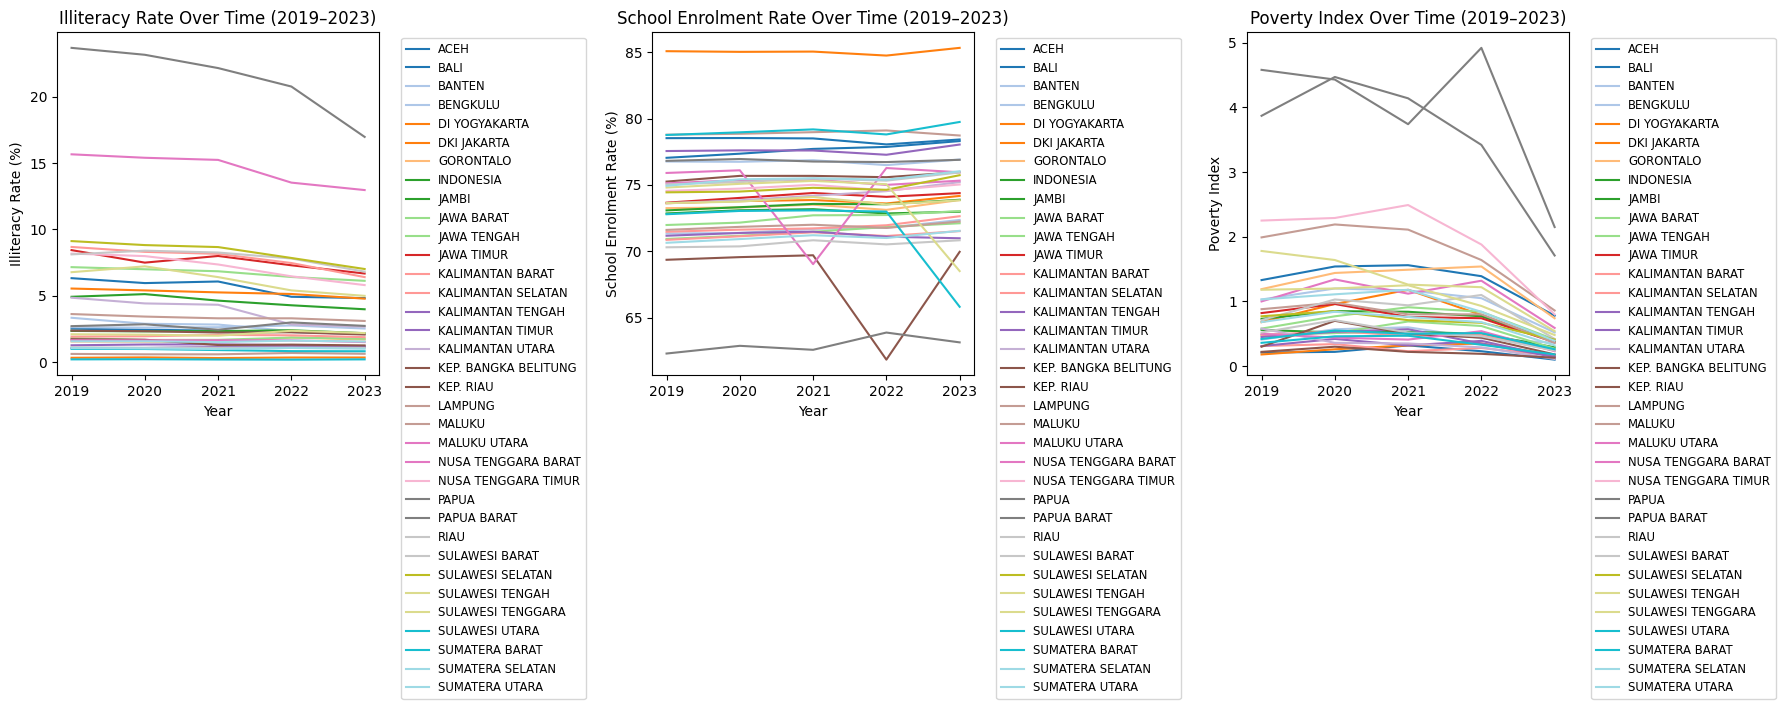

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Load the combined dataset
data = pd.read_csv('combined_literacy_enrolment_wide_poverty_index_2019_2023.csv')

plt.figure(figsize=(18, 6))


# Get the number of unique provinces
num_provinces = len(data['Province'].unique())

# Create a colormap with enough unique colors
colors = plt.cm.tab20(np.linspace(0, 1, num_provinces))

# Illiteracy Rate
plt.subplot(1, 3, 1)
for i,province in enumerate(data['Province'].unique()):
    province_data = data[data['Province'] == province]
    years = [int(col.split('_')[-1]) for col in province_data.columns[2:7]]  # Extract years
    plt.plot(years, province_data.iloc[:, 2:7].values.flatten(), label=province, color=colors[i])
plt.title('Illiteracy Rate Over Time (2019–2023)')
plt.xlabel('Year')
plt.ylabel('Illiteracy Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# School Enrolment Rate
plt.subplot(1, 3, 2)
for i,province in enumerate(data['Province'].unique()):
    province_data = data[data['Province'] == province]
    years = [int(col.split('_')[-1]) for col in province_data.columns[7:12]]  # Extract years
    plt.plot(years, province_data.iloc[:, 7:12].values.flatten(), label=province, color=colors[i])
plt.title('School Enrolment Rate Over Time (2019–2023)')
plt.xlabel('Year')
plt.ylabel('School Enrolment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Poverty Index
plt.subplot(1, 3, 3)
for i,province in enumerate(data['Province'].unique()):
    province_data = data[data['Province'] == province]
    years = [int(col.split('_')[-1]) for col in province_data.columns[12:17]]  # Extract years
    plt.plot(years, province_data.iloc[:, 12:17].values.flatten(), label=province, color=colors[i])
plt.title('Poverty Index Over Time (2019–2023)')
plt.xlabel('Year')
plt.ylabel('Poverty Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

## 2.2 Scatter Plots

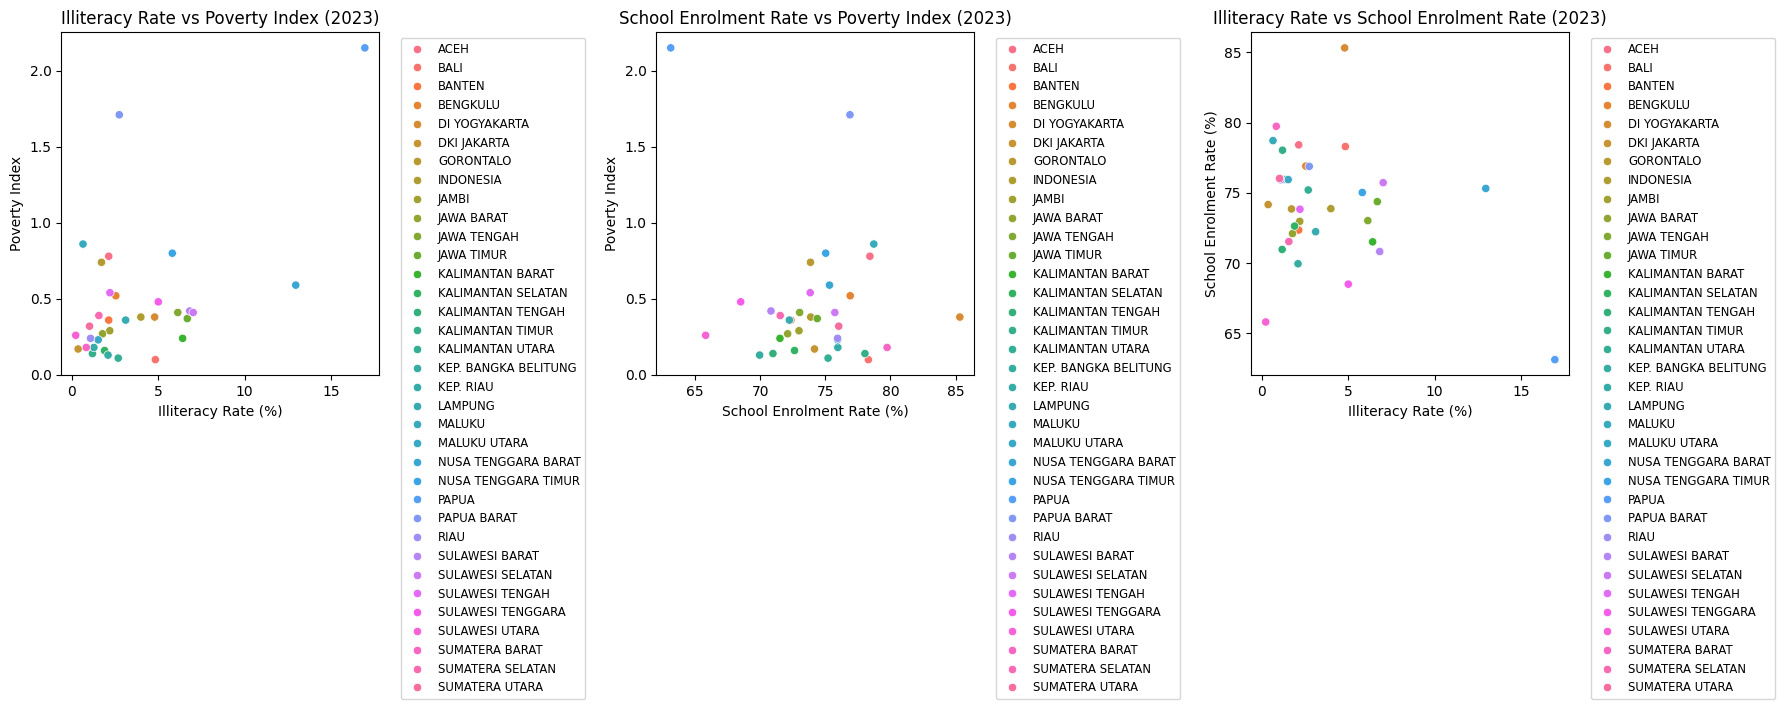

In [ ]:
# Scatter plot to explore relationships
plt.figure(figsize=(18, 6))

# Illiteracy Rate vs Poverty Index
plt.subplot(1, 3, 1)
sns.scatterplot(x=data['Illiteracy Rate_2023'], y=data['Poverty_Index_2023'], hue=data['Province'])
plt.title('Illiteracy Rate vs Poverty Index (2023)')
plt.xlabel('Illiteracy Rate (%)')
plt.ylabel('Poverty Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# School Enrolment Rate vs Poverty Index
plt.subplot(1, 3, 2)
sns.scatterplot(x=data['School Enrolment Rate_2023'], y=data['Poverty_Index_2023'], hue=data['Province'])
plt.title('School Enrolment Rate vs Poverty Index (2023)')
plt.xlabel('School Enrolment Rate (%)')
plt.ylabel('Poverty Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Illiteracy Rate vs School Enrolment Rate
plt.subplot(1, 3, 3)
sns.scatterplot(x=data['Illiteracy Rate_2023'], y=data['School Enrolment Rate_2023'], hue=data['Province'])
plt.title('Illiteracy Rate vs School Enrolment Rate (2023)')
plt.xlabel('Illiteracy Rate (%)')
plt.ylabel('School Enrolment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

## 2.3 Distribution of Variables

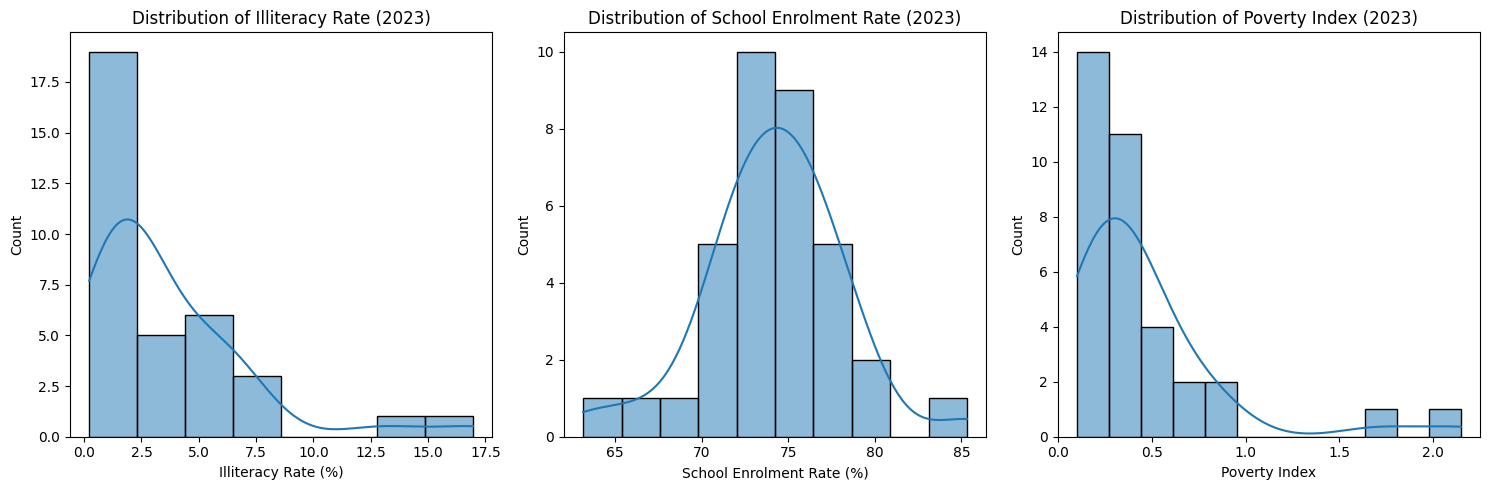

In [ ]:
# Visualize the distribution of key variables
plt.figure(figsize=(15, 5))

# Illiteracy Rate
plt.subplot(1, 3, 1)
sns.histplot(data['Illiteracy Rate_2023'], kde=True)
plt.title('Distribution of Illiteracy Rate (2023)')
plt.xlabel('Illiteracy Rate (%)')

# School Enrolment Rate
plt.subplot(1, 3, 2)
sns.histplot(data['School Enrolment Rate_2023'], kde=True)
plt.title('Distribution of School Enrolment Rate (2023)')
plt.xlabel('School Enrolment Rate (%)')

# Poverty Index
plt.subplot(1, 3, 3)
sns.histplot(data['Poverty_Index_2023'], kde=True)
plt.title('Distribution of Poverty Index (2023)')
plt.xlabel('Poverty Index')

plt.tight_layout()
plt.show()

## 2.4 Correlation Heatmap

Correlation Matrix:
                            Illiteracy Rate_2023  School Enrolment Rate_2023  \
Illiteracy Rate_2023                    1.000000                   -0.304093   
School Enrolment Rate_2023             -0.304093                    1.000000   
Poverty_Index_2023                      0.540672                   -0.213104   

                            Poverty_Index_2023  
Illiteracy Rate_2023                  0.540672  
School Enrolment Rate_2023           -0.213104  
Poverty_Index_2023                    1.000000  


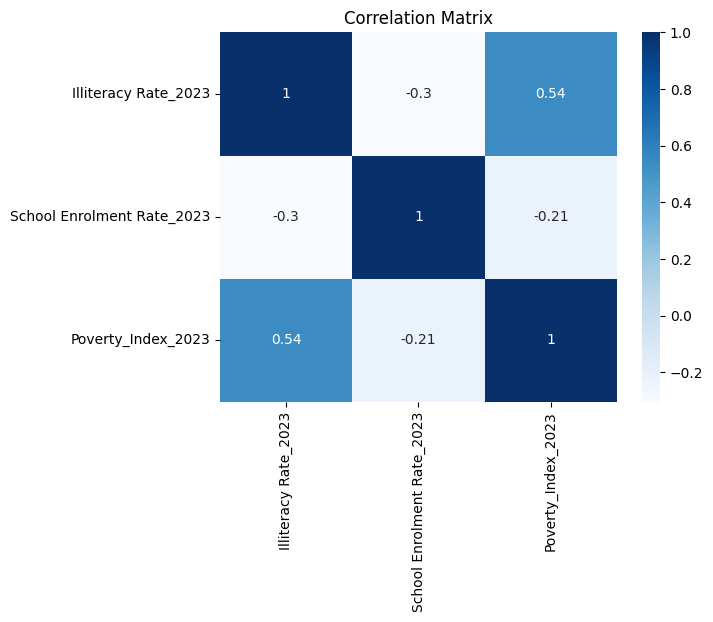

In [ ]:
# Correlation matrix
corr_matrix = data[['Illiteracy Rate_2023', 'School Enrolment Rate_2023', 'Poverty_Index_2023']].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Heatmap of correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

# 3. Model Training

##3.1 K-means Clustering

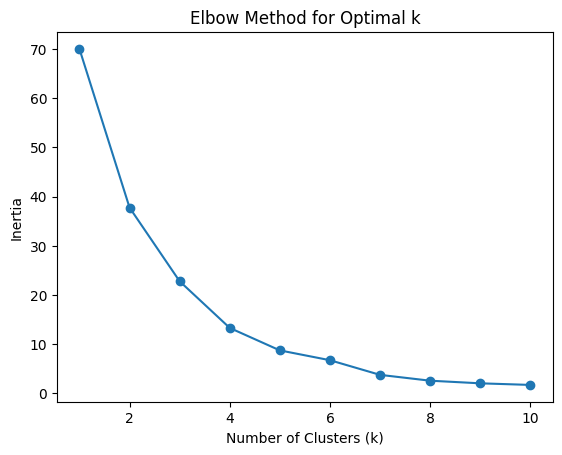

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Feature Selection
features = data[['Illiteracy Rate_2023', 'Poverty_Index_2023']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()



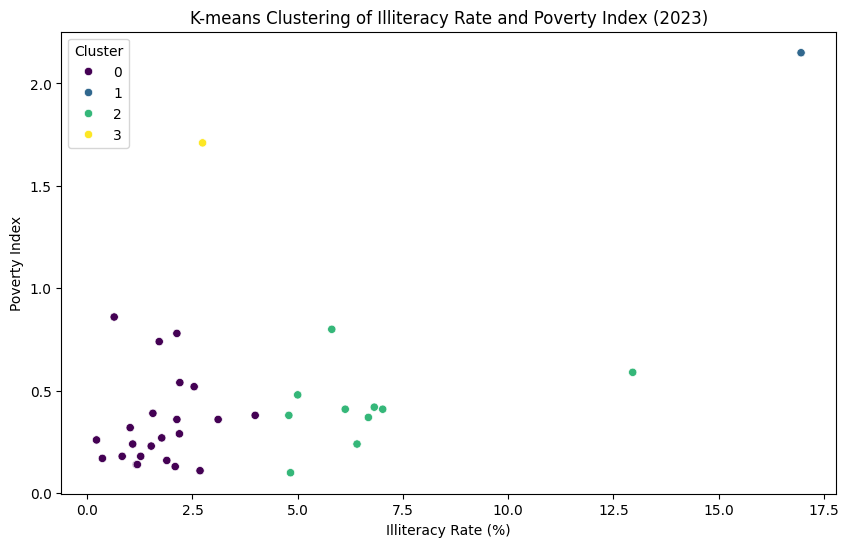

In [ ]:
# Choose k=4 based on the Elbow Method
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Illiteracy Rate_2023'], y=data['Poverty_Index_2023'], hue=data['Cluster'], palette='viridis')
plt.title('K-means Clustering of Illiteracy Rate and Poverty Index (2023)')
plt.xlabel('Illiteracy Rate (%)')
plt.ylabel('Poverty Index')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Evaluate clustering using Silhouette Score
score = silhouette_score(features_scaled, data['Cluster'])
print(f"Silhouette Score: {score}")

# Interpret the clusters
for cluster in range(k):
    print(f"\nCluster {cluster}:")
    cluster_data = data[data['Cluster'] == cluster]
    print(cluster_data[['Province', 'Illiteracy Rate_2023', 'Poverty_Index_2023']])
    print(f"Average Illiteracy Rate: {cluster_data['Illiteracy Rate_2023'].mean():.2f}")
    print(f"Average Poverty Index: {cluster_data['Poverty_Index_2023'].mean():.2f}")



Silhouette Score: 0.4763709827610173

Cluster 0:
                Province  Illiteracy Rate_2023  Poverty_Index_2023
0                   ACEH                  2.13                0.78
2                 BANTEN                  2.13                0.36
3               BENGKULU                  2.54                0.52
5            DKI JAKARTA                  0.36                0.17
6              GORONTALO                  1.71                0.74
7              INDONESIA                  3.99                0.38
8                  JAMBI                  2.19                0.29
9             JAWA BARAT                  1.77                0.27
13    KALIMANTAN SELATAN                  1.89                0.16
14     KALIMANTAN TENGAH                  1.17                0.14
15      KALIMANTAN TIMUR                  1.19                0.14
16      KALIMANTAN UTARA                  2.68                0.11
17  KEP. BANGKA BELITUNG                  2.09                0.13
18           